<a href="https://colab.research.google.com/github/thanujTa/machine-learning-projects/blob/main/Transfer_Learning_Part_3_Scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensoFlow part3: Scaling up(Food Vision Mini)

In [ ]:
!nvidia-smi

Mon Apr 11 08:23:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
## creating helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-04-11 09:21:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-04-11 09:21:03 (74.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys , walk_through_dir

In [4]:
# get the data  of 101 classes

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

--2022-04-11 09:29:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.6.128, 142.251.120.128, 74.125.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.6.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   198MB/s    in 8.7s    

2022-04-11 09:29:28 (177 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [6]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheesecake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ceviche'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/seaweed_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/eggs_benedict'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/clam_chowder'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/scallops'.
There are 0 directories and 250 images in '101_food

In [11]:
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode= "categorical",
                                                                                image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


from tensorflow.python.ops.variables import model_variables
from gc import callbacks
## Train a Big Dog model with transfer learning on 10% of 101 food classes

Here are the steps we are going to take:

* create a modelcheckpoint callbacks [x]
* create a data augmentation layer to build data augmentation right into the model_variables [x]
* build a  headless functional EfficientNetB0 backboned Model []
* compile our model []
* feature extract for 5 passes(5 epochs on the train datast and validate on 15% of the test data, to save epoch time ) []

In [14]:
# create checkpoint callback
checkpoint_path  = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = "val_accuracy",
                                                         save_best_only  = True)

In [16]:
#create data augmentation layer to incorporate it right into the model

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# setup data augmentation

data_augmentation = Sequential([
      preprocessing.RandomFlip("horizontal"),
      preprocessing.RandomRotation(0.2),
      preprocessing.RandomHeight(0.2),
      preprocessing.RandomWidth(0.2),
      preprocessing.RandomZoom(0.2),
      # preproccesing.Rescaling(1/255.) # rescale inputs of images between 0 and 1 are required by models like ResNetV2
], name = "data_augmentation")


In [19]:
# setup the base model and freeze its layers (this will extract features)

base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

#setup model architecture with trainable top layers

inputs = layers.Input(shape = (224,224,3), name = "input_layer")
x  = data_augmentation(inputs) # augment images
x = base_model(x, training = False) # put the model in inferece mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name = "global_avg_poo_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = "softmax", name = "output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs)

In [20]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_poo_layer (Globa  (None, 1280)             0         
 lAveragePooling2D)                                              
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [21]:
# compile the model

model_1.compile (loss = "categorical_crossentropy",
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics = ["accuracy"])

history_all_classes_10_percent = model_1.fit(train_data_all_10_percent,
                                             epochs = 5,
                                             validation_data = test_data,
                                             validation_steps = int(0.15 * len(test_data)),
                                             callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 136s 500ms/step - loss: 3.4666 - accuracy: 0.2475 - val_loss: 2.6866 - val_accuracy: 0.4028
Epoch 2/5
237/237 [==============================] - 96s 401ms/step - loss: 2.3517 - accuracy: 0.4626 - val_loss: 2.2184 - val_accuracy: 0.4756
Epoch 3/5
237/237 [==============================] - 89s 375ms/step - loss: 1.9755 - accuracy: 0.5336 - val_loss: 2.1077 - val_accuracy: 0.4759
Epoch 4/5
237/237 [==============================] - 79s 332ms/step - loss: 1.7535 - accuracy: 0.5760 - val_loss: 2.0220 - val_accuracy: 0.4828
Epoch 5/5
237/237 [==============================] - 79s 330ms/step - loss: 1.5970 - accuracy: 0.6145 - val_loss: 1.9772 - val_accuracy: 0.4963


In [22]:
fine_tuning_results = model_1.evaluate(test_data)

790/790 [==============================] - 103s 131ms/step - loss: 1.7191 - accuracy: 0.5508


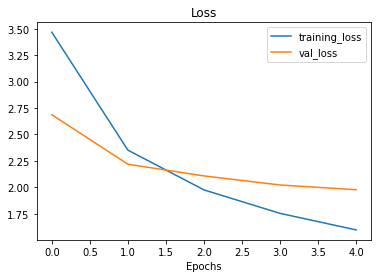

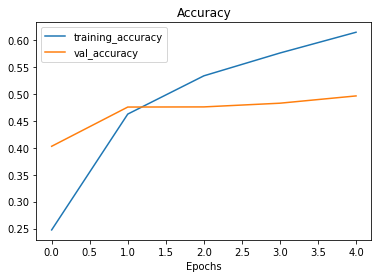

In [23]:
plot_loss_curves(history_all_classes_10_percent)

## Fine Tuning

In [48]:
# unfreezing all the layers in the base model

base_model.trainable = True

# refreeze every layer exvept for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [50]:
# Recompile the model

model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics = ["accuracy"])



In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

In [53]:
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model_1.fit(train_data_all_10_percent,
            epochs = fine_tune_epochs,
            validation_data = test_data,
            validation_steps = int(0.15* len(test_data)),
            initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 84s 318ms/step - loss: 1.3459 - accuracy: 0.6547 - val_loss: 1.9272 - val_accuracy: 0.5024
Epoch 6/10
237/237 [==============================] - 75s 316ms/step - loss: 1.2333 - accuracy: 0.6830 - val_loss: 1.9335 - val_accuracy: 0.5061
Epoch 7/10
237/237 [==============================] - 67s 282ms/step - loss: 1.1597 - accuracy: 0.6927 - val_loss: 1.9723 - val_accuracy: 0.4963
Epoch 8/10
237/237 [==============================] - 66s 276ms/step - loss: 1.0844 - accuracy: 0.7122 - val_loss: 1.9111 - val_accuracy: 0.5048
Epoch 9/10
237/237 [==============================] - 66s 276ms/step - loss: 1.0137 - accuracy: 0.7364 - val_loss: 1.9062 - val_accuracy: 0.5082
Epoch 10/10
237/237 [==============================] - 66s 278ms/step - loss: 0.9831 - accuracy: 0.7373 - val_loss: 1.9105 - val_accuracy: 0.5026


In [55]:
feature_extraction_history = model_1.evaluate(test_data)

790/790 [==============================] - 105s 133ms/step - loss: 1.6054 - accuracy: 0.5769


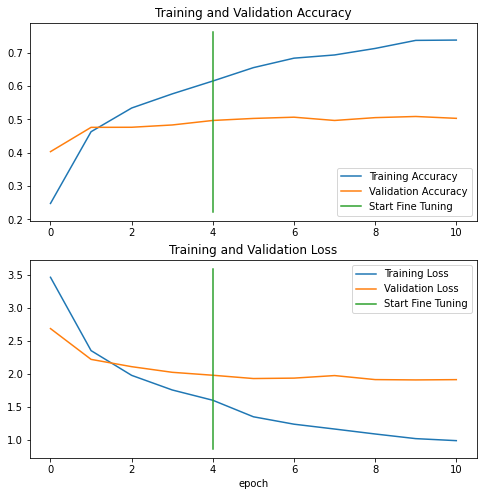

In [57]:
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5)

## Evaluating the performance of the big dog model across all different classes



In [58]:
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-04-11 11:20:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 173.194.74.128, 173.194.192.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   172MB/s    in 0.3s    

2022-04-11 11:20:39 (172 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

model_2 = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model/")

In [60]:
evaluate_loaded_model = model_2.evaluate(test_data)

790/790 [==============================] - 107s 133ms/step - loss: 1.8027 - accuracy: 0.6078


## making predictions with our trained model


In [62]:
pred_probs = model_2.predict(test_data, verbose=1)


790/790 [==============================] - 97s 123ms/step


In [63]:
# how many predictions are there?
len(pred_probs)

25250

In [64]:
# whats the shape of our predictions?
pred_probs.shape

(25250, 101)

In [65]:
# lets explore what the first 10 predictions look like
pred_probs[:10]

array([[5.9541941e-02, 3.5742332e-06, 4.1376889e-02, ..., 1.4138899e-09,
        8.3530460e-05, 3.0897565e-03],
       [9.6401680e-01, 1.3753089e-09, 8.4779976e-04, ..., 5.4286684e-05,
        7.8363253e-12, 9.8467334e-10],
       [9.5925868e-01, 3.2534019e-05, 1.4867033e-03, ..., 7.1891884e-07,
        5.4398350e-07, 4.0276311e-05],
       ...,
       [4.7313324e-01, 1.2931301e-07, 1.4805583e-03, ..., 5.9749611e-04,
        6.6969820e-05, 2.3469329e-05],
       [4.4571780e-02, 4.7265351e-07, 1.2258515e-01, ..., 6.3498578e-06,
        7.5319103e-06, 3.6778715e-03],
       [7.2438985e-01, 1.9249777e-09, 5.2310857e-05, ..., 1.2291447e-03,
        1.5793171e-09, 9.6395503e-05]], dtype=float32)

In [68]:
# what does the first prediction probs look like
pred_probs[0], len(pred_probs[0]), sum(pred_probs[0])

(array([5.9541941e-02, 3.5742332e-06, 4.1376889e-02, 1.0660903e-09,
        8.1613996e-09, 8.6639682e-09, 8.0926134e-07, 8.5652442e-07,
        1.9858850e-05, 8.0977554e-07, 3.1727692e-09, 9.8673388e-07,
        2.8532100e-04, 7.8049661e-10, 7.4230990e-04, 3.8915794e-05,
        6.4740016e-06, 2.4977169e-06, 3.7891397e-05, 2.0678806e-07,
        1.5538471e-05, 8.1506892e-07, 2.6230925e-06, 2.0010653e-07,
        8.3827712e-07, 5.4215743e-06, 3.7391112e-06, 1.3150788e-08,
        2.7761345e-03, 2.8051816e-05, 6.8561651e-10, 2.5574524e-05,
        1.6688934e-04, 7.6409645e-10, 4.0452869e-04, 1.3150487e-08,
        1.7957433e-06, 1.4448400e-06, 2.3062853e-02, 8.2465459e-07,
        8.5366531e-07, 1.7138503e-06, 7.0526130e-06, 1.8402382e-08,
        2.8553984e-07, 7.9482870e-06, 2.0682012e-06, 1.8525193e-07,
        3.3619781e-08, 3.1522335e-04, 1.0410886e-05, 8.5448306e-07,
        8.4741890e-01, 1.0555387e-05, 4.4094719e-07, 3.7404192e-05,
        3.5306137e-05, 3.2489079e-05, 6.7313988e

In [70]:
# we get one prediction probability per class
print(f"number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"what prediction probability sample 0 looks like :\n{pred_probs[0]}")
print(f"the class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

number of prediction probabilities for sample 0: 101
what prediction probability sample 0 looks like :
[5.9541941e-02 3.5742332e-06 4.1376889e-02 1.0660903e-09 8.1613996e-09
 8.6639682e-09 8.0926134e-07 8.5652442e-07 1.9858850e-05 8.0977554e-07
 3.1727692e-09 9.8673388e-07 2.8532100e-04 7.8049661e-10 7.4230990e-04
 3.8915794e-05 6.4740016e-06 2.4977169e-06 3.7891397e-05 2.0678806e-07
 1.5538471e-05 8.1506892e-07 2.6230925e-06 2.0010653e-07 8.3827712e-07
 5.4215743e-06 3.7391112e-06 1.3150788e-08 2.7761345e-03 2.8051816e-05
 6.8561651e-10 2.5574524e-05 1.6688934e-04 7.6409645e-10 4.0452869e-04
 1.3150487e-08 1.7957433e-06 1.4448400e-06 2.3062853e-02 8.2465459e-07
 8.5366531e-07 1.7138503e-06 7.0526130e-06 1.8402382e-08 2.8553984e-07
 7.9482870e-06 2.0682012e-06 1.8525193e-07 3.3619781e-08 3.1522335e-04
 1.0410886e-05 8.5448306e-07 8.4741890e-01 1.0555387e-05 4.4094719e-07
 3.7404192e-05 3.5306137e-05 3.2489079e-05 6.7313988e-05 1.2852399e-08
 2.6220215e-10 1.0318094e-05 8.5742751e-05 1.

In [71]:
test_data.class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [73]:
test_data.class_names[52]

'gyoza'

In [ ]:
# get the pred classes of each label